In [62]:
import os
import tensorflow as tf
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import pickle
from keras import Sequential
from keras.layers import *
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import datetime as dt
import sys
from keras.models import load_model
from sklearn.utils import shuffle
from math import ceil

seed_constant = 1
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

SEQUENCE_LENGTH = 25
IMAGE_HEIGHT,IMAGE_WIDTH = 220, 340

CLASSES_LIST = ['away','map','photo','trap','son','where','breakfast','deaf','bright']
# CLASS_DICT = {0:'away',1:'map',2:'photo',3:'trap',4:'son',5:'where',6:'breakfast',7:'deaf',8:'bright'}

data_dir = os.path.join('datasets','Augmented2')
# data_dir = os.path.join('datasets','argentinian')
# CLASS_DICT = {index : sign for index,sign in enumerate(os.listdir(data_dir))}

In [63]:
x = []
y = []
for index,sign in enumerate(CLASSES_LIST):
    for video in os.listdir(f'{data_dir}/{sign}'):
        x.append(os.path.join(data_dir,sign,video))
        y.append(index)
        
y_onehot = to_categorical(y).astype(int)

In [64]:
x_train,x_test,y_train,y_test = train_test_split(x,y_onehot,shuffle=True,test_size=0.25)

batch_size = 8
validation_steps = ceil(len(x_test) / batch_size)
training_steps = ceil(len(x_train) / batch_size)

In [65]:
len(y_train)

2700

In [66]:
def load_video(video_path):
    
    frames_list = []
    cap = cv2.VideoCapture(video_path)
    video_frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)
    
    for frame_counter in range(SEQUENCE_LENGTH):

        cap.set(cv2.CAP_PROP_POS_FRAMES,frame_counter * skip_frames_window)
        
        ret,frame = cap.read()
        if not ret:
            break
            
        # resized_frame = cv2.resize(frame,(IMAGE_WIDTH,IMAGE_HEIGHT))
        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        normalized_frame = (gray/255.0).astype(np.float32)
        normalized_frame = np.expand_dims(normalized_frame,axis=2)
        
        frames_list.append(normalized_frame)
        
    cap.release()
    
    while len(frames_list) < SEQUENCE_LENGTH:
        frames_list.append(np.zeros(IMAGE_HEIGHT,IMAGE_WIDTH,1))
        
    return frames_list

def video_generator(video_paths,labels,batch_size):
    
    while True:
            
        for i in range(0,len(video_paths),batch_size):
            batch_paths = video_paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            
            batch_videos = []
            for path in batch_paths:
                video = load_video(path)
                batch_videos.append(video)
                
            yield np.array(batch_videos),np.array(batch_labels)

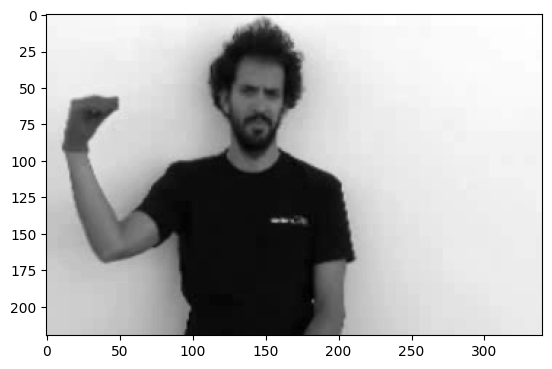

In [68]:
plt.imshow(np.array(load_video('datasets/Augmented2/away/58.mp4'))[24],cmap='gray')

In [7]:
# Assuming 'gen' is your generator
gen = video_generator(x_train, y_train, batch_size)

for i in range(training_steps):
    videos_batch, labels_batch = next(gen)
    print("Shape of videos batch: ", videos_batch.shape)



Shape of videos batch:  (4, 25, 220, 340, 1)
Shape of videos batch:  (4, 25, 220, 340, 1)


KeyboardInterrupt: 

In [69]:
def create_lrcn_model():
    model = Sequential()

    # **************************************************************************************************
    model.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu'),
                              input_shape = (SEQUENCE_LENGTH,IMAGE_HEIGHT,IMAGE_WIDTH,1)))
    model.add(TimeDistributed(MaxPooling2D(4,4)))
    model.add(TimeDistributed(Dropout(0.25)))

    # **************************************************************************************************
    model.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(4,4)))
    model.add(TimeDistributed(Dropout(0.25)))
    
    # **************************************************************************************************
    model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(2,2)))
    model.add(TimeDistributed(Dropout(0.25)))

    # **************************************************************************************************
    model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(2,2)))
    model.add(TimeDistributed(Dropout(0.25)))
              
    # **************************************************************************************************
    model.add(TimeDistributed(Flatten()))
    # **************************************************************************************************
    model.add(LSTM(32))
    # **************************************************************************************************
    model.add(Dense(len(CLASSES_LIST),activation='softmax'))
    
    return model

In [70]:
model = create_lrcn_model()

In [71]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeD  (None, 25, 220, 340, 16   160       
 istributed)                 )                                   
                                                                 
 time_distributed_27 (TimeD  (None, 25, 55, 85, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_28 (TimeD  (None, 25, 55, 85, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_29 (TimeD  (None, 25, 55, 85, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_30 (TimeD  (None, 25, 13, 21, 32)   

In [72]:
train_gen = video_generator(x_train,y_train,batch_size)
val_gen = video_generator(x_test,y_test,batch_size)

In [73]:
early_stopping_callback = EarlyStopping(monitor='val_loss',patience=15,mode='min',restore_best_weights=True)

model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics= ['accuracy'])

training_history = model.fit(train_gen,validation_data=val_gen,
                             epochs=100,callbacks = [early_stopping_callback],
                             validation_steps=validation_steps,steps_per_epoch=training_steps)

Epoch 1/100
338/338 [==============================] - 546s 2s/step - loss: 1.9669 - accuracy: 0.1826 - val_loss: 1.6619 - val_accuracy: 0.2978
Epoch 2/100
338/338 [==============================] - 587s 2s/step - loss: 1.4879 - accuracy: 0.3689 - val_loss: 1.2979 - val_accuracy: 0.4644
Epoch 3/100
338/338 [==============================] - 577s 2s/step - loss: 1.1260 - accuracy: 0.5404 - val_loss: 1.0139 - val_accuracy: 0.5544
Epoch 4/100
338/338 [==============================] - 560s 2s/step - loss: 0.8477 - accuracy: 0.6489 - val_loss: 1.1970 - val_accuracy: 0.5478
Epoch 5/100
338/338 [==============================] - 571s 2s/step - loss: 0.8844 - accuracy: 0.6437 - val_loss: 0.7416 - val_accuracy: 0.6922
Epoch 6/100
338/338 [==============================] - 573s 2s/step - loss: 0.6306 - accuracy: 0.7522 - val_loss: 0.9594 - val_accuracy: 0.6500
Epoch 7/100
338/338 [==============================] - 572s 2s/step - loss: 0.5351 - accuracy: 0.7948 - val_loss: 0.5671 - val_accuracy:

In [74]:
evaluation_history = model.evaluate(val_gen,steps=validation_steps)

113/113 [==============================] - 74s 657ms/step - loss: 0.0345 - accuracy: 0.9911


In [75]:
def plot_metrics(model_training_history,metric_name_1,metric_name_2,plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))
    
    plt.plot(epochs,metric_value_1,'blue',label = metric_name_1)
    plt.plot(epochs,metric_value_2,'red', label = metric_name_2)
    
    plt.title(str(plot_name))
    plt.legend()

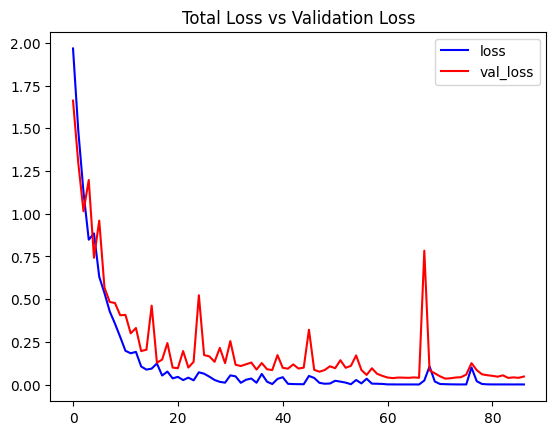

In [76]:
plot_metrics(training_history,'loss','val_loss','Total Loss vs Validation Loss')

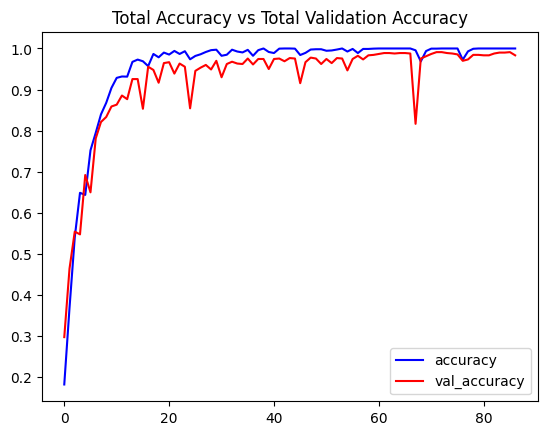

In [77]:
plot_metrics(training_history,'accuracy','val_accuracy','Total Accuracy vs Total Validation Accuracy')

In [79]:
os.makedirs('models',exist_ok=True)
model_evaluation_loss,model_evaluation_accuracy = evaluation_history

# date_time_format = '%Y_%m_%d__%H_%M_%S'
# current_date_time_dt = dt.datetime.now()
# current_date_time_string = dt.datetime.strftime(current_date_time_dt,date_time_format)

classes = len(CLASSES_LIST)

model_file_name = f'models/SignLang3_model_classes={classes}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}_with_colorAugmentation(3600, 25, 220, 340, 1).keras'

model.save(model_file_name)